In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import os
import conda
import pandas as pd
import numpy as np
import json
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
import matplotlib.dates as mdates
import math

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd

from shapely.geometry import Point

from scipy.interpolate import interp1d

import datetime
import scipy.stats as st
from scipy.optimize import curve_fit

from tqdm import tqdm
import networkx as nx
import sys
sys.path.insert(1, '../graph_construction/')
from WI_graph_functions import *

In [2]:
WILakes  = pd.read_pickle("../graph_construction/WILakes.df")
WIRivers = pd.read_pickle("../graph_construction/WIRivers.df")
agland   = pd.read_pickle("../graph_construction/agland.df")

HUC8  = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC8/HUC8.shp")
HUC10 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC10/HUC10.shp")
HUC12 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC12/HUC12.shp")

WItofroms       = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms.csv")
WItofroms_lakes = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms_lakes.csv")
WItofroms_agg   = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms_agg.csv")

WI    = gpd.GeoDataFrame.from_file("../graph_construction/lakes_rivers/WI/WI.shp")
CAFOS = gpd.GeoDataFrame.from_file("../graph_construction/CAFOS_shp/CAFOS_shp.shp")

In [3]:
lake_index = pd.read_csv("../DNR_data/lake_index_WBIC_COMID.csv")

In [4]:
WILakes_sub = WILakes.copy(deep=True)
WILakes_sub["TPavg"] = 0
WILakes_sub["chlaavg"] = 0
lakegdf = gpd.GeoDataFrame(columns=WILakes_sub.columns)

lake_index["TPavg"]   = 0
lake_index["chlaavg"] = 0

counter = 0
counter5 = 0


for i in tqdm(range(len(lake_index))):
    lake_num = lake_index.lake_index.iloc[i]
    comid = lake_index.COMID.iloc[i]
    DNR = pd.read_csv(f"../DNR_data/Lakes/Lake{lake_num}/DNR_data.csv")
    DNR.date = pd.to_datetime(DNR.date)
    
    if lake_index.COMID.iloc[i] != 0:
        
        if len(DNR.TP[DNR.TP.notna()& (DNR.TP != "ND*")]) >5 and len(DNR.chla[DNR.chla.notna()& (DNR.chla != "ND*")]) > 5:
            counter5 += 1

        if len(DNR.TP[DNR.TP.notna()& (DNR.TP != "ND*")]) >50 and len(DNR.chla[DNR.chla.notna()& (DNR.chla != "ND*")]) > 50:
            counter += 1
            lakegdf = lakegdf.append(WILakes_sub[WILakes_sub.COMID == comid])
            lakegdf.TPavg.iloc[-1]     = np.average(DNR.TP.values[DNR.TP.notna() & (DNR.TP != "ND*")].astype(float))
            lakegdf.chlaavg.iloc[-1]   = np.average(DNR.chla.values[DNR.chla.notna()& (DNR.chla != "ND*")].astype(float))
            lake_index.TPavg.iloc[i]   = np.average(DNR.TP.values[DNR.TP.notna() & (DNR.TP != "ND*")].astype(float))
            lake_index.chlaavg.iloc[i] = np.average(DNR.chla.values[DNR.chla.notna()& (DNR.chla != "ND*")].astype(float))

100%|████████████████████████████████████████████████████████████████████████████████| 871/871 [00:17<00:00, 49.31it/s]


In [ ]:
#s = tofroms.TOCOMID
#r = tofroms.FROMCOMID
#Madtofroms = tofroms[s.isin(Madrivers.COMID.values[:]) & r.isin(Madrivers.COMID.values[:])]

def plot_with_watersheds(G, G_pos, G_cols, lake_gdf, river_gdf, HUC12, HUC10, WI_too = False,comid_too = False, comid=0, node_size = 20, arrowsize=5):
    all_nodes = [i for i in G.nodes]
    rivers = river_gdf[river_gdf.COMID.isin(all_nodes)]
    lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)]
    
    huc12_rivs  = [i for i in rivers.huc12.values]
    
    huc12_lakes = [i for i in lakes.huc12.values]
    huc12_vals = huc12_lakes + huc12_rivs
    huc10_vals = [i for i in lakes.huc10.values]
    huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
    huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
    
    fig, ax = plt.subplots(figsize=(13,13))
    nx.draw_networkx(G,pos=G_pos,node_size=node_size,with_labels=False,ax=ax,arrowsize=arrowsize,node_color=G_cols)
    huc12s.plot(ax=ax, color="none", edgecolor="black")
    lakes.plot(ax=ax, color="skyblue")
    if WI_too:
        WI.plot(ax=ax, color="none", edgecolor="black")
    if comid_too:
        WILakes[WILakes.COMID == comid].centroid.plot(ax=ax, markersize=400,marker="*", color="gold",edgecolors="black",linewidth = 1,zorder=151)
        #WILakes[WILakes.COMID == comid].plot(ax=ax, color="red")
    CAFOS[CAFOS.huc12.isin(huc12_vals)].centroid.plot(ax=ax, markersize=50, color="purple",marker="s", zorder=150)
    
    legend_elements = [
                   Line2D([0],[0], markersize=10, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
                   Line2D([0],[0], markersize=10, label="River Node",marker='o',color='red',linestyle="None"),
                   Line2D([0],[0], markersize=10, label="CAFO", marker="s", color="purple", linestyle="None"),
                   Line2D([0],[0], markersize=18, label="Altoona Lake", marker="*", color="gold", linestyle="None", markeredgecolor="black"),
                   Patch(facecolor="green", edgecolor="none", label="Agricultural Land")]

    ax.legend(handles=legend_elements, loc = 'upper left',fontsize=22)
    #HUC12WI[(HUC12WI.HUC10=='0709000205')|(HUC12WI.HUC10=='0709000206')|(HUC12WI.HUC10=='0709000207')].plot(ax=ax,color="none",edgecolor="black")
    #WILakes[(WILakes.HUC10=='0709000205')|(WILakes.HUC10=='0709000206')|(WILakes.HUC10=='0709000207')].plot(ax=ax)
    #WIRivers[(WIRivers.HUC10=='0709000205')|(WIRivers.HUC10=='0709000206')|(WIRivers.HUC10=='0709000207')].plot(ax=ax)

    plt.show()
    
def add_CAFOS_to_graph(G_old, lake_gdf, river_gdf, CAFOS):
    
    G = G_old.copy()
    all_nodes = [i for i in G.nodes]
    node_df = pd.concat([lake_gdf[["COMID", 'huc12', 'geometry']][lake_gdf.COMID.isin(all_nodes)].copy(), river_gdf[['COMID', 'huc12','geometry']][river_gdf.COMID.isin(all_nodes)].copy()])
    
    for i in range(len(CAFOS)):
        huc = CAFOS.huc12.iloc[i]
        point = CAFOS.geometry.iloc[i]
        cafo_name = CAFOS.Node.iloc[i]
        
        df_in_huc = node_df[node_df.huc12 == huc].copy()
        df_in_huc = df_in_huc.reset_index(drop=True)
        
        distances = df_in_huc.distance(point)
        
        if len(df_in_huc) != 0:
            comid_to_connect = df_in_huc.COMID.values[distances == min(distances)][0]
        
            G.add_edge(cafo_name, comid_to_connect)
    return G
        
def build_graph_with_pollutants(tofroms,lake_gdf, river_gdf, source):
    node_df = pd.concat([lake_gdf[["COMID", 'huc12']], river_gdf[['COMID', 'huc12']]])
    
    G = nx.DiGraph()
    
    for j in range(len(tofroms)):
        from_node = tofroms.FROMCOMID.iloc[j]
        to_node   = tofroms.TOCOMID.iloc[j]
        
        if from_node != to_node:
            G.add_edge(from_node, to_node)
    
    all_nodes = [i for i in G.nodes]
    
    for i in range(len(source)):
        huc = source.huc12.iloc[i]
        new_df = node_df[(node_df.huc12 == huc) & (node_df.COMID.isin(all_nodes))]
        
        for j in range(len(new_df)):
            from_node = source.Node.iloc[i]
            to_node = new_df.COMID.iloc[j]
            G.add_edge(from_node, to_node)
    return G

def get_pos_dict_with_pollutant(G, lake_gdf, riv_gdf, source):
    
    G_pos = dict()
    
    node_colors= []
    node_size = []
    
    
    for j in tqdm((G.nodes)):
        
        if np.isin(j, riv_gdf.COMID.values):
            poly_val = riv_gdf.geometry[riv_gdf.COMID == j]
            cent_val = poly_val.centroid
            node_colors.append("red")
            node_size.append(10)
        elif np.isin(j, source.Node.values):
            cent_val = source.geometry[source.Node == j]
            node_colors.append("orange")
            node_size.append(30)
        else:
            poly_val = lake_gdf.geometry[lake_gdf.COMID == j]
            cent_val = poly_val.centroid
            node_colors.append("blue")
            node_size.append(10)
            
        G_pos[j] = (np.array([cent_val.x.values[0], cent_val.y.values[0]]))

    return G_pos, node_colors, node_size


def add_source_to_graph(G, lake_gdf, river_gdf, source):
    all_nodes = [i for i in G.nodes]
    node_df = pd.concat([lake_gdf[["COMID", 'huc12', 'geometry']][lake_gdf.COMID.isin(all_nodes)].copy(), river_gdf[['COMID', 'huc12','geometry']][river_gdf.COMID.isin(all_nodes)].copy()])
    
    for i in range(len(source)):
        huc = source.huc12.iloc[i]
        point = source.geometry.iloc[i]
        cafo_name = source.Node.iloc[i]
        
        df_in_huc = node_df[node_df.huc12 == huc].copy()
        df_in_huc = df_in_huc.reset_index(drop=True)
        
        distances = df_in_huc.distance(point)
        
        if len(df_in_huc) != 0:
            comid_to_connect = df_in_huc.COMID.values[distances == min(distances)][0]
        
            G.add_edge(cafo_name, comid_to_connect)
    return G

In [ ]:
G_lakes = build_graph(WItofroms_lakes)

In [ ]:
G_CAFOS = add_CAFOS_to_graph(G_lakes, WILakes, WIRivers, CAFOS)

G_CAFOS_pos, node_colors_CAFOS, node_size_CAFOS = get_pos_dict_with_pollutant(G_CAFOS, WILakes, WIRivers, CAFOS)

In [ ]:
G_agg = build_graph(WItofroms_agg)

In [ ]:
G_CAFOS2 = add_CAFOS_to_graph(G_agg, WILakes, WIRivers, CAFOS)

G_CAFOS_pos2, node_colors_CAFOS2, node_size_CAFOS2 = get_pos_dict_with_pollutant(G_CAFOS2, WILakes, WIRivers, CAFOS)

In [12]:
#eut_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg>60) & (lake_index.chlaavg>15)]).astype(int)
#cln_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg<15) & (lake_index.chlaavg<5) & (lake_index.TPavg != 0) & (lake_index.chlaavg != 0)]).astype(int)

eut_lake_index = lake_index[(lake_index.TPavg>110) & (lake_index.chlaavg>30)]
cln_lake_index = lake_index[(lake_index.TPavg<10.8) & (lake_index.chlaavg<5) & (lake_index.TPavg != 0) & (lake_index.chlaavg != 0)]

eut_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg>110) & (lake_index.chlaavg>30)]).astype(int)
cln_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg<10.8) & (lake_index.chlaavg<5) & (lake_index.TPavg != 0) & (lake_index.chlaavg != 0)]).astype(int)

G_CAFOS_nodes = [i for i in G_CAFOS.nodes]

eut_node_index = eut_lake_index[eut_lake_index.COMID.isin(G_CAFOS_nodes)]
cln_node_index = cln_lake_index[cln_lake_index.COMID.isin(G_CAFOS_nodes)]

eut_nodes = np.intersect1d(eut_COMIDs, G_CAFOS_nodes).astype(int)
cln_nodes = np.intersect1d(cln_COMIDs, G_CAFOS_nodes).astype(int)

In [13]:
def make_cs2_fig(ax, node, G, G_pos, lake_name, lake_tp, lake_chla, lake_gdf=WILakes, river_gdf=WIRivers, node_size = 4, arrowsize=5, CAFOS=CAFOS):
    def get_gdfs(G, comid, lake_gdf=lake_gdf, river_gdf=river_gdf, HUC12 = HUC12, HUC10=HUC10, agland=agland):
        all_nodes = [i for i in G.nodes]
        all_nodes = all_nodes + [comid]
        rivers = river_gdf[river_gdf.COMID.isin(all_nodes)]
        lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)]
        
        huc12_rivs  = [i for i in rivers.huc12.values]
        
        huc12_lakes = [i for i in lakes.huc12.values]
        huc12_vals = huc12_lakes + huc12_rivs
        huc2       = lake_gdf.huc2[lake_gdf.COMID == comid].iloc[0]
        
        
        huc12_vals = [i for i in huc12_vals if i > huc2*1e10 and i < (huc2*1e10 + 1e10 - 1)]
        huc10_vals = [i for i in lakes.huc10.values]
        aglands    = agland[agland.huc12.isin(huc12_vals)]
        huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
        huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
        
        aglands    = agland[agland.huc12.isin(huc12_vals)].copy(deep=True)

        
        huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
        huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
        #print("starting overlay")
        aglands    = gpd.overlay(aglands, huc12s,how="intersection")
        #print("done with overlay")
        
        return lakes, rivers, huc12s, aglands
    
    
        
    g, cols = get_upstream_graph(G, node, lake_gdf, river_gdf)
    
    lakes, rivers, huc12s, aglands = get_gdfs(g, node)

                               
    huc12_vals = huc12s.huc12.values
    land_frac = sum(aglands.area)/sum(huc12s.area)
    
    aglands.plot(ax=ax, color="forestgreen")
    huc12s.plot(ax=ax, color="none", edgecolor="black")
    lakes.plot(ax=ax, color="skyblue")
    nx.draw_networkx(g,pos=G_pos,node_size=node_size,with_labels=False,ax=ax,arrowsize=arrowsize,node_color=cols)
    
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #if False:
    #    WI.plot(ax=ax, color="none", edgecolor="black")
    if True:
        WILakes[WILakes.COMID == node].centroid.plot(ax=ax, markersize=350,marker="*", color="gold",edgecolors="black",linewidth = 1,zorder=151)
    if len(CAFOS[CAFOS.huc12.isin(huc12_vals)]) > 0:
        CAFOS[CAFOS.huc12.isin(huc12_vals)].centroid.plot(ax=ax, markersize=10, color="orange",marker="s", zorder=150)
        #WILakes[WILakes.COMID == comid].plot(ax=ax, color="red")

    return land_frac
        
    #ax.set_title(f"{lake_name} \nTP avg = {np.round(lake_tp,1)} "+ r"$mg/m^3$" +f"\nchla avg = {np.round(lake_chla,1)} " +r"$mg/m^3$"+f"\nAg Land = {np.round(land_frac*100,1)} %",fontsize= 12,loc='left')
        

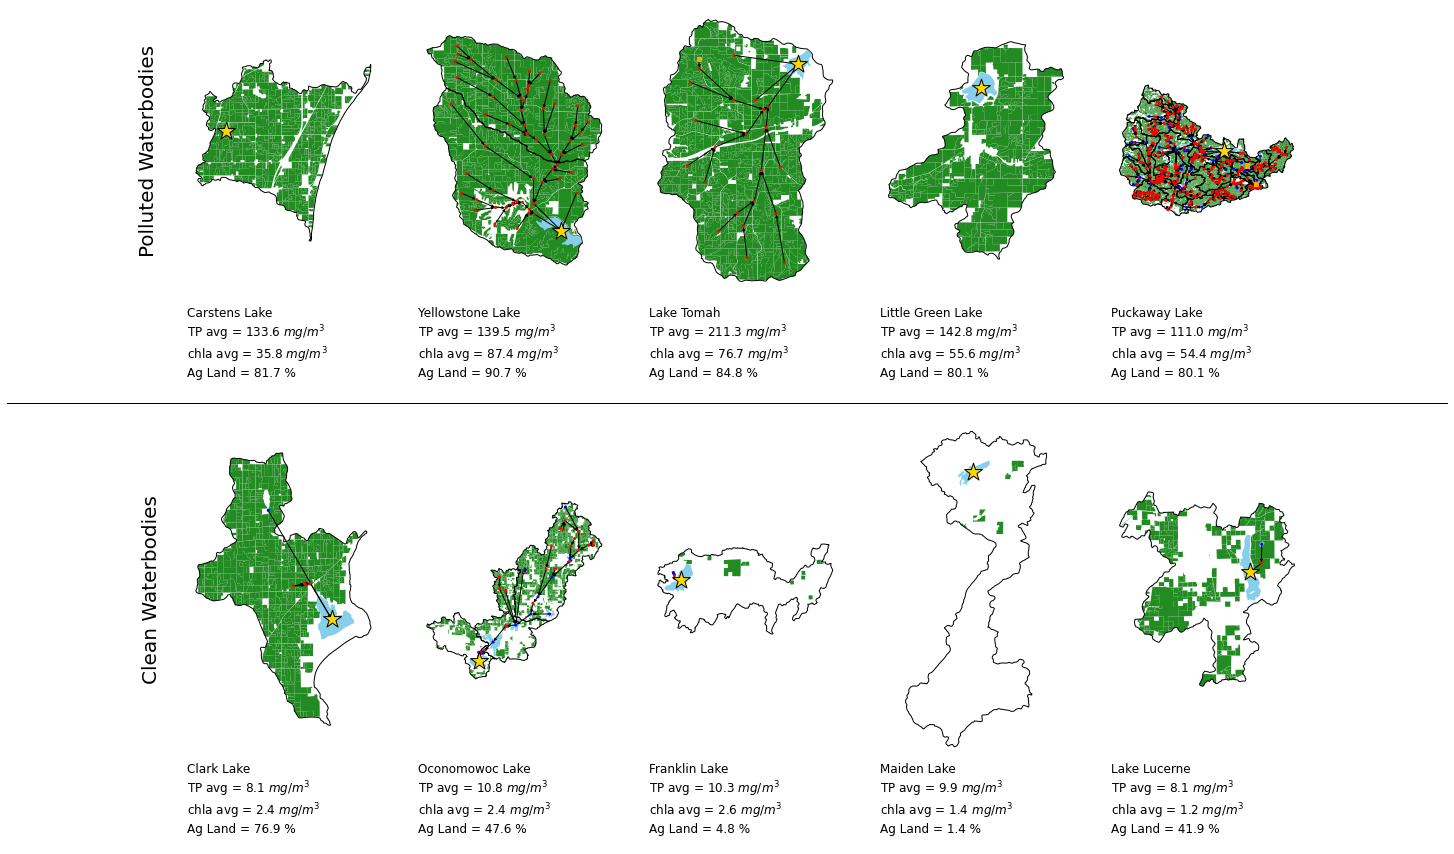

In [20]:
fig, ax = plt.subplots(6,5,figsize=(20,16), gridspec_kw={"height_ratios":[4,.1, .1, 4, .3, .1]})#[.001,4,.0001,.001,4]})

for i in range(5):
    lake_vals = eut_node_index[eut_node_index.COMID == eut_nodes[i]]
    
    lake_name = lake_vals.lakename.iloc[0]
    lake_TP   = lake_vals.TPavg.iloc[0]
    lake_chla = lake_vals.chlaavg.iloc[0]
    
    land_frac = make_cs2_fig(ax[0,i], eut_nodes[i], G_CAFOS, G_CAFOS_pos,lake_name, lake_TP, lake_chla)
    ax[2,i].set_title(f"{lake_name} \nTP avg = {np.round(lake_TP,1)} "+ r"$mg/m^3$" +f"\nchla avg = {np.round(lake_chla,1)} " +r"$mg/m^3$"+f"\nAg Land = {np.round(land_frac*100,1)} %",fontsize= 12,loc='left')
    ax[2,i].set_axis_off()
    ax[1,i].set_axis_off()
    
for j in range(5):
    
    lake_vals = cln_node_index[cln_node_index.COMID == cln_nodes[j]]
    
    
    lake_name = lake_vals.lakename.iloc[0]
    lake_TP   = lake_vals.TPavg.iloc[0]
    lake_chla = lake_vals.chlaavg.iloc[0]
    
    land_frac = make_cs2_fig(ax[3,j], cln_nodes[j], G_CAFOS, G_CAFOS_pos,lake_name, lake_TP, lake_chla)
    ax[5,j].set_title(f"{lake_name} \nTP avg = {np.round(lake_TP,1)} "+ r"$mg/m^3$" +f"\nchla avg = {np.round(lake_chla,1)} " +r"$mg/m^3$"+f"\nAg Land = {np.round(land_frac*100,1)} %",fontsize= 12,loc='left')
    ax[5,j].set_axis_off()
    ax[4,j].set_axis_off()
    
ax[0,0].set_ylabel(f"Polluted Waterbodies\n",fontsize=20)
ax[3,0].set_ylabel(f"Clean Waterbodies\n",fontsize=20)
line = plt.Line2D([0,1],[.51,.51], color="black", linewidth=1)
fig.add_artist(line)
plt.savefig("Test.pdf")
plt.show()

In [21]:
def get_cs2_metrics(node_list, graph):
    
    def get_ag_frac(all_nodes, lake_gdf, river_gdf, agland, HUC12, HUC10):
        rivers = river_gdf[river_gdf.COMID.isin(all_nodes)]
        lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)]
        
        huc12_rivs  = [i for i in rivers.huc12.values]
        
        huc12_lakes = [i for i in lakes.huc12.values]
        huc12_vals = huc12_lakes + huc12_rivs
        huc10_vals = [i for i in lakes.huc10.values]
        aglands    = agland[agland.huc12.isin(huc12_vals)]
        huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
        huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
        
        aglands    = agland[agland.huc12.isin(huc12_vals)].copy(deep=True)
        if node == 6866527:
            huc12s = huc12s[huc12s.huc12 < 50000000000]
        
        huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
        huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
        aglands    = gpd.overlay(aglands, huc12s,how="intersection")
        
        return sum(aglands.area)/sum(huc12s.area)
    
    count_CAFOS        = 0
    count_not_in_graph = 0
    count_in_graph     = 0
    count_ag_frac50    = 0
    count_10_nodes     = 0
    count_50_nodes     = 0
    count_headwater    = 0
    tot                = len(node_list)
    
    gnodes = [i for i in graph.nodes]
    
    # check if cafo is in huc12 watershed if lake is in graph but not connected to cafo
    
    ag_fracs = []
    
    for k, node in enumerate(node_list):
        if np.isin(node, gnodes):
            count_in_graph += 1
            

            
            g, cols = get_upstream_graph(graph, node, WILakes, WIRivers)
            subnodes = [i for i in g.nodes]
            if len(subnodes) == 0:
                count_headwater += 1
                
                huc12_val = WILakes.huc12[WILakes.COMID == node].iloc[0]
                
                if len(CAFOS[CAFOS.huc12 == huc12_val]) > 0:
                    count_CAFOS += 1
            
            ag_frac_val = get_ag_frac(subnodes + [node], WILakes, WIRivers, agland, HUC12, HUC10)
            ag_fracs = np.append(ag_fracs, ag_frac_val)
            
            
            if ag_frac_val > .5:
                count_ag_frac50 += 1
            
            if len(subnodes) > 10:
                count_10_nodes += 1
                
            if len(subnodes) > 50:
                count_50_nodes += 1
                
            for i in subnodes:
                if np.isin(i, CAFOS.Node.values):
                    count_CAFOS += 1
                    break
            
        else:
            count_not_in_graph += 1
            huc12_val = WILakes.huc12[WILakes.COMID == node].iloc[0]
                
            if len(CAFOS[CAFOS.huc12 == huc12_val]) > 0:
                count_CAFOS += 1
                
            ag_frac_val = get_ag_frac([node], WILakes, WIRivers, agland, HUC12, HUC10)
            ag_fracs = np.append(ag_fracs, ag_frac_val)
        #print("Done with iteration ", k, "out of ", len(node_list))
                
    print()
    print("The number of lakes connected to CAFOS is             ", count_CAFOS, "  ", count_CAFOS/tot)
    print("The number of lakes not in the graph is               ", count_not_in_graph, "   ", count_not_in_graph/tot)
    print("The number of lakes in the graph is                   ", count_in_graph, "   ", count_in_graph/tot)
    print("The number of lakes that are headwaters is            ", count_headwater, "   ", count_headwater/tot)
    print("The number of lakes with a 50% ag fraction is         ", count_ag_frac50, "   ", count_ag_frac50/tot)
    print("The number of lakes connected to 10 upstream nodes is ", count_10_nodes, "   ", count_10_nodes/tot)
    print("The number of lakes connected to 50 upstream nodes is ", count_50_nodes, "   ", count_50_nodes/tot)
    print()
    print("The average agricultural land fraction is ", np.average(ag_fracs))
    

In [22]:
eut_general_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg>60) & (lake_index.chlaavg>15)]).astype(int)
cln_general_COMIDs = np.unique(lake_index.COMID.values[(lake_index.TPavg<15) & (lake_index.chlaavg<5) & (lake_index.TPavg != 0) & (lake_index.chlaavg != 0)]).astype(int)


In [23]:
get_cs2_metrics(eut_general_COMIDs, G_CAFOS)


The number of lakes connected to CAFOS is              6    0.3333333333333333
The number of lakes not in the graph is                3     0.16666666666666666
The number of lakes in the graph is                    15     0.8333333333333334
The number of lakes that are headwaters is             2     0.1111111111111111
The number of lakes with a 50% ag fraction is          14     0.7777777777777778
The number of lakes connected to 10 upstream nodes is  9     0.5
The number of lakes connected to 50 upstream nodes is  6     0.3333333333333333

The average agricultural land fraction is  0.7076205941751279


In [24]:
get_cs2_metrics(cln_general_COMIDs, G_CAFOS)


The number of lakes connected to CAFOS is              4    0.06666666666666667
The number of lakes not in the graph is                36     0.6
The number of lakes in the graph is                    24     0.4
The number of lakes that are headwaters is             10     0.16666666666666666
The number of lakes with a 50% ag fraction is          10     0.16666666666666666
The number of lakes connected to 10 upstream nodes is  3     0.05
The number of lakes connected to 50 upstream nodes is  1     0.016666666666666666

The average agricultural land fraction is  0.38891437297707304
